FINAL HOMEWORK 

KATIE HIPPE

In [49]:
## packages and data 

import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
from torch import nn
import tqdm

#load in clean infrared data 
df = pd.read_csv('data/IR_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)

#scale back to correct units
keys = list(df.keys()[:-1])
df[keys] = df[keys]*1e-2

#remove outlier
df = df.where(df.q000 > -100)

#make sure index is in order
df = df.sort_index()

#df = df.dropna()



print(df.shape)
df.head()

(619213, 10)


,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-02-04 16:40:00,-61.31,-59.45,-55.30,-52.59,-47.00,-36.92,-26.560,-4.4163,15.19,Thunderstorm Wind
2018-02-04 16:45:00,-61.90,-59.13,-55.37,-52.52,-47.68,-38.00,-26.753,-6.9400,15.32,Thunderstorm Wind
2018-02-04 16:50:00,-61.16,-58.93,-55.35,-52.55,-48.17,-39.07,-27.013,-8.8400,15.62,Thunderstorm Wind
2018-02-04 16:55:00,-61.63,-58.87,-55.38,-52.68,-48.34,-40.16,-27.030,-8.9163,14.27,Thunderstorm Wind
2018-02-04 17:00:00,-61.67,-58.82,-55.42,-52.81,-48.38,-40.75,-27.240,-9.0526,6.57,Thunderstorm Wind


In [4]:
# mess with the data some more
def clear_nan(X,y):
    tmp = np.hstack([X,y.reshape([y.shape[0],1])])
    df_tmp = pd.DataFrame(tmp)
    df_tmp = df_tmp.dropna(how='any')
    tmp = df_tmp.to_numpy()
    X = tmp[:,:-1]
    y = tmp[:,-1:]
    y = np.asarray(y.squeeze(),dtype=int)
    return X,y

def adjust_keys(df,keyadd,dask=False,dropevent=False):
    if dask:
        keys = df.columns
        newkeys = []
        newkeys.append('dtime')
        newkeys = newkeys + list(keys[1:-1]+keyadd)
        newkeys.append(keys[-1])
    else:
        keys = df.keys()
        newkeys = list(keys[:-1]+keyadd)
        newkeys.append(keys[-1])
        
    df.columns = newkeys
    if dropevent:
        df = df.drop(columns='event')
        
    if dask:
        df['dtime'] = df['dtime'].astype(np.datetime64)
    return df 


def get_right_units_vil(vil):
    """they scaled VIL weird, so this unscales it"""
    tmp = np.zeros(vil.shape)
    idx = np.where(vil <=5)
    tmp[idx] = 0
    idx = np.where((vil>5)*(vil <= 18))
    tmp[idx] = (vil[idx] -2)/90.66
    idx = np.where(vil>18)
    tmp[idx] = np.exp((vil[idx] - 83.9)/38.9)
    return tmp



def load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,36,1),class_labels=True,dropzeros=False):
    df_ir = pd.read_csv(path_to_data + 'IR_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
    df_wv = pd.read_csv(path_to_data + 'WV_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
    df_vis = pd.read_csv(path_to_data + 'VIS_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
    df_vil = pd.read_csv(path_to_data + 'VIL_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)
    df_li = pd.read_csv(path_to_data + 'LI_stats_master.csv',index_col=0,low_memory=False,parse_dates=True)

    #get rid of that outlier 
    df_wv = df_wv.where(df_wv.q000 > -10000)
    
    if dropzeros:
        df_li = df_li.where(df_li.c >= 1)
    
    #get rid of NaNs
    idx_keep = np.where(~df_vis.isna().all(axis=1).values)[0]
    df_ir = df_ir.iloc[idx_keep]
    df_wv = df_wv.iloc[idx_keep]
    df_vis = df_vis.iloc[idx_keep]
    df_vil = df_vil.iloc[idx_keep]
    df_li = df_li.iloc[idx_keep]

    #make sure idx are in order 
    df_ir = df_ir.sort_index()
    df_wv = df_wv.sort_index()
    df_vis = df_vis.sort_index()
    df_vil = df_vil.sort_index()
    df_li = df_li.sort_index()

    #adjust keys so merging doesnt make keys confusing
    df_ir = adjust_keys(df_ir,'_ir')
    df_wv = adjust_keys(df_wv,'_wv')
    df_vis = adjust_keys(df_vis,'_vi')
    df_vil = adjust_keys(df_vil,'_vl')
    df_li = adjust_keys(df_li,'_li')

    #drop event column 
    df_ir= df_ir.drop(columns='event')
    df_wv= df_wv.drop(columns='event')
    df_vis= df_vis.drop(columns='event')
    df_vil= df_vil.drop(columns='event')
    df_li = df_li.drop(columns='event')
    
    #slice on time 
    train_slice = slice('2017-01-01','2019-06-01')
    other_slice = slice('2019-06-01','2019-12-31')

    df_ir_tr = df_ir[train_slice]
    df_ir_ot = df_ir[other_slice]
    df_wv_tr = df_wv[train_slice]
    df_wv_ot = df_wv[other_slice]
    df_vis_tr = df_vis[train_slice]
    df_vis_ot = df_vis[other_slice]
    df_vil_tr = df_vil[train_slice]
    df_vil_ot = df_vil[other_slice]
    df_li_tr = df_li[train_slice]
    df_li_ot = df_li[other_slice]

    #throw every other week into each the val and test 
    va = np.arange(22,52,2)
    te = np.arange(23,53,2)
    dtime = pd.to_datetime(df_ir_ot.index)

    idx_v = np.array([],dtype=int)
    for v in va:
        tmp = np.where(dtime.isocalendar().week == v)[0]
        if len(tmp) == 0:
            continue
        else:
            idx_v = np.append(idx_v,tmp)

    idx_t = np.array([],dtype=int)      
    for t in te:
        tmp = np.where(dtime.isocalendar().week == t)[0]
        if len(tmp) == 0:
            continue
        else:
            idx_t = np.append(idx_t,tmp)


    df_ir_va = df_ir_ot.iloc[idx_v]
    df_ir_te = df_ir_ot.iloc[idx_t]
    df_wv_va = df_wv_ot.iloc[idx_v]
    df_wv_te = df_wv_ot.iloc[idx_t]
    df_vis_va = df_vis_ot.iloc[idx_v]
    df_vis_te = df_vis_ot.iloc[idx_t]
    df_vil_va = df_vil_ot.iloc[idx_v]
    df_vil_te = df_vil_ot.iloc[idx_t]
    df_li_va = df_li_ot.iloc[idx_v]
    df_li_te = df_li_ot.iloc[idx_t]
    
    X_train = np.hstack([df_ir_tr.to_numpy()*1e-2,df_wv_tr.to_numpy()*1e-2,df_vis_tr.to_numpy()*1e-4,get_right_units_vil(df_vil_tr.to_numpy())])
    X_validate = np.hstack([df_ir_va.to_numpy()*1e-2,df_wv_va.to_numpy()*1e-2,df_vis_va.to_numpy()*1e-4,get_right_units_vil(df_vil_va.to_numpy())])
    X_test= np.hstack([df_ir_te.to_numpy()*1e-2,df_wv_te.to_numpy()*1e-2,df_vis_te.to_numpy()*1e-4,get_right_units_vil(df_vil_te.to_numpy())])

    #choose 
    X_train = X_train[:,features_to_keep]
    X_validate = X_validate[:,features_to_keep]
    X_test = X_test[:,features_to_keep]

    #make class labels
    if class_labels:
        y_train = np.zeros(X_train.shape[0],dtype=int)
        y_train[np.where(df_li_tr.c_li.values >= 1)] = 1

        y_validate = np.zeros(X_validate.shape[0],dtype=int)
        y_validate[np.where(df_li_va.c_li.values >= 1)] = 1

        y_test = np.zeros(X_test.shape[0],dtype=int)
        y_test[np.where(df_li_te.c_li.values >= 1)] = 1
    else:
        y_train = df_li_tr.c_li.values
        y_validate = df_li_va.c_li.values
        y_test = df_li_te.c_li.values



    #clean out nans 
    X_train,y_train = clear_nan(X_train,y_train)
    X_validate,y_validate = clear_nan(X_validate,y_validate)
    X_test,y_test = clear_nan(X_test,y_test)
    
    return (X_train,y_train),(X_validate,y_validate),(X_test,y_test)

In [53]:
# load in data using helper functions above


(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,1,1),class_labels=True)

In [55]:
# check in on our code

print(X_train.shape)
print(y_train.shape)

(446320, 1)
(446320,)


In [56]:
#load model from sklearn
from sklearn.linear_model import LogisticRegression

#initialize
model = LogisticRegression()

print(model)

LogisticRegression()


In [57]:
model = model.fit(X_train,y_train)

In [64]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_val_score

model = RidgeClassifierCV()


print(X_train.shape)
print(y_train.shape)


model = model.fit(X_train, y_train)


(446320, 1)
(446320,)


In [65]:


print("Training Score: {}".format(model.score(X_train, y_train)))
print("Testing Score: {}".format(model.score(X_test, y_test)))

scores = cross_val_score(model, X_train, y_train, cv=5)
print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

Training Score: 0.7721029754436279
Testing Score: 0.8148866448204374
0.771538358128697 accuracy with a standard deviation of 0.034411705269489216


In [ ]:
# now that we're satisfied it works alright, we may continue onwards by evaluating how well 
# the ridge classification works based on a function of kept features

time = np.arange(0, 37)
training_acc = []
testing_acc = []


for i in range(1, 37):
    (X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,i,1),class_labels=True)
    
    # ridge regression
    model = RidgeClassifierCV()

    model = model.fit(X_train, y_train)

    training_acc.append(model.score(X_train, y_train))
    testing_acc.append(model.score(X_test, y_test))

    print("Done with iteration: ", i)



Done with iteration:  1
Done with iteration:  2
Done with iteration:  3
Done with iteration:  4
Done with iteration:  5
Done with iteration:  6
Done with iteration:  7
Done with iteration:  8
Done with iteration:  9
Done with iteration:  10
Done with iteration:  11
Done with iteration:  12
Done with iteration:  13
Done with iteration:  14
Done with iteration:  15
Done with iteration:  16
Done with iteration:  17
Done with iteration:  18
Done with iteration:  19
Done with iteration:  20
Done with iteration:  21
Done with iteration:  22
Done with iteration:  23
Done with iteration:  24
Done with iteration:  25
Done with iteration:  26
Done with iteration:  27
Done with iteration:  28
Done with iteration:  29
Done with iteration:  30
Done with iteration:  31
Done with iteration:  32
Done with iteration:  33
Done with iteration:  34
Done with iteration:  35
Done with iteration:  36


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


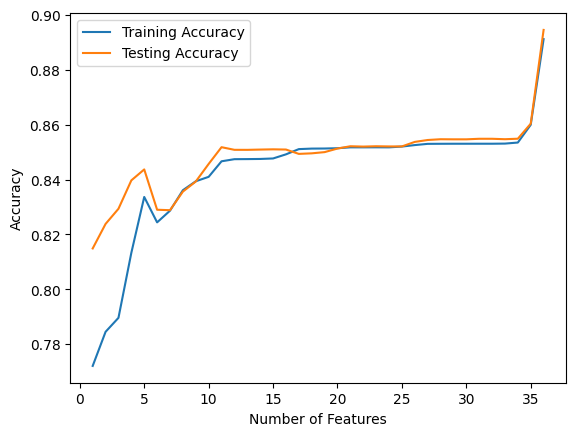

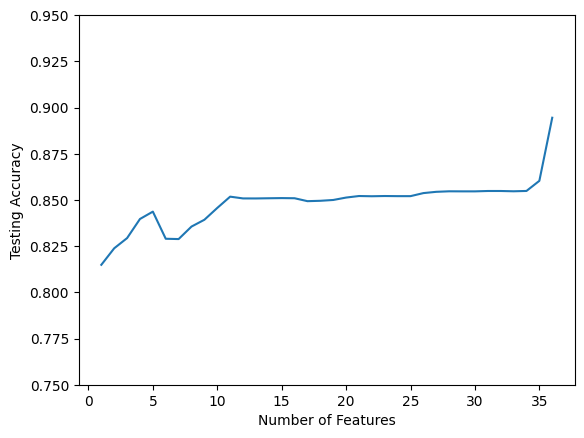

In [80]:
# given these outputs, make some plots
time = np.arange(1,37)
print(time)
plt.plot(time, training_acc,label= "Training Accuracy")
plt.plot(time, testing_acc, label="Testing Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.plot(time, testing_acc)
plt.xlabel("Number of Features")
plt.ylabel("Testing Accuracy")
plt.ylim(.75,.95)
plt.show()



In [41]:
# regression using a variety

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier 
from sklearn.tree import DecisionTreeRegressor

# load in data with all features
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)
    

print(X_train.shape)

#initialize
model_list = [RidgeClassifier(), LinearRegression(),DecisionTreeRegressor(), RidgeClassifier(), RidgeClassifier()]

print(model_list)

(222051, 36)
[RidgeClassifier(), LinearRegression(), DecisionTreeRegressor(), RidgeClassifier(), RidgeClassifier()]


In [42]:
import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [07:29<00:00, 89.88s/it] 


In [ ]:
#determine unconditional mean, sum R in each bin. But then devide by master counts
def boxbin(x,y,xedge,yedge,c=None,figsize=(5,5),cmap='viridis',mincnt=10,vmin=None,vmax=None,edgecolor=None,powernorm=False,
           ax=None,normed=False,method='mean',quantile=None,alpha=1.0,cbar=True,unconditional=False,master_count=np.array([])):
    
    """ This function will grid data for you and provide the counts if no variable c is given, or the median if 
    a variable c is given. In the future I will add functionallity to do the median, and possibly quantiles. 
    
    x: 1-D array 
    y: 1-D array 
    xedge: 1-D array for xbins 
    yedge: 1-D array for ybins
    
    c: 1-D array, same len as x and y 
    
    returns
    
    axis handle 
    cbar handle 
    C matrix (counts or median values in bin)
    
    """
    
    midpoints = np.empty(xedge.shape[0]-1)
    for i in np.arange(1,xedge.shape[0]):
        midpoints[i-1] = xedge[i-1] + (np.abs(xedge[i] - xedge[i-1]))/2.
    
    #note on digitize. bin 0 is outside to the left of the bins, bin -1 is outside to the right
    ind1 = np.digitize(x,bins = xedge) #inds of x in each bin
    ind2 = np.digitize(y,bins = yedge) #inds of y in each bin
    
    
    #drop points outside range 
    outsideleft = np.where(ind1 != 0)
    ind1 = ind1[outsideleft]
    ind2 = ind2[outsideleft]
    if c is None:
        pass
    else:
        c = c[outsideleft]
        
    outsideright = np.where(ind1 != len(xedge))
    ind1 = ind1[outsideright]
    ind2 = ind2[outsideright]
    if c is None:
        pass
    else:
        c = c[outsideright]
        
    outsideleft = np.where(ind2 != 0)
    ind1 = ind1[outsideleft]
    ind2 = ind2[outsideleft]
    if c is None:
        pass
    else:
        c = c[outsideleft]
    outsideright = np.where(ind2 != len(yedge))
    ind1 = ind1[outsideright]
    ind2 = ind2[outsideright]
    if c is None:
        pass
    else:
        c = c[outsideright]
    

    if c is None:
        c = np.zeros(len(ind1))
        df = pd.DataFrame({'x':ind1-1,'y':ind2-1,'c':c})
        df2 = df.groupby(["x","y"]).count()
        df = df2.where(df2.values >= mincnt).dropna()
        C = np.ones([xedge.shape[0]-1,yedge.shape[0]-1])*-9999
        for i,ii in enumerate(df.index.values):
            C[ii[0],ii[1]] = df.c.values[i]
        C = np.ma.masked_where(C == -9999,C)
        
        if normed:
            n_samples = np.ma.sum(C)
            C = C/n_samples
            C = C*100
            print('n_samples= {}'.format(n_samples))
        
        if ax is None:
            fig = plt.figure(figsize=(5,5))
            ax = plt.gca()
        else:
            pass
            
        if powernorm:
            pm = ax.pcolormesh(xedge,yedge,C.transpose(),cmap=cmap,edgecolor=edgecolor,norm=colors.PowerNorm(gamma=0.5),vmin=vmin,vmax=vmax,alpha=alpha)
            
            if cbar:
                cbar = plt.colorbar(pm,ax=ax)
            else:
                cbar = pm 
        else:
            pm = ax.pcolormesh(xedge,yedge,C.transpose(),cmap=cmap,vmin=vmin,vmax=vmax,edgecolor=edgecolor,alpha=alpha)
            if cbar:
                cbar = plt.colorbar(pm,ax=ax)
            else:
                cbar = pm 
            
        return ax,cbar,C
    
    elif unconditional:
    
        df = pd.DataFrame({'x':ind1-1,'y':ind2-1,'c':c})
        if method=='mean':
            df2 = df.groupby(["x","y"])['c'].sum()
            
        df3 = df.groupby(["x","y"]).count()
        df2 = df2.to_frame()
        df2.insert(1,'Count',df3.values)
        df = df2.where(df2.Count >= mincnt).dropna()
        C = np.ones([xedge.shape[0]-1,yedge.shape[0]-1])
        for i,ii in enumerate(df.index.values):
            C[ii[0],ii[1]] = df.c.values[i]
                
        C = C/master_count.values

        if ax is None:
            fig = plt.figure(figsize=(5,5))
            ax = plt.gca()
        else:
            pass
        
        if powernorm:
            pm = ax.pcolor(xedge,yedge,C.transpose(),cmap=cmap,vmin=vmin,vmax=vmax,norm=colors.PowerNorm(gamma=0.5),alpha=alpha)
            if cbar:
                cbar = plt.colorbar(pm,ax=ax)
        else:
            
            pm = ax.pcolor(xedge,yedge,C.transpose(),cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha)
            if cbar: 
                cbar = plt.colorbar(pm,ax=ax)
        
        
    else:
        df = pd.DataFrame({'x':ind1-1,'y':ind2-1,'c':c})
        if method=='mean':
            df2 = df.groupby(["x","y"])['c'].mean()
        elif method=='std':
            df2 = df.groupby(["x","y"])['c'].std()
        elif method=='median':
            df2 = df.groupby(["x","y"])['c'].median()
        elif method=='qunatile':
            if quantile is None:
                print('No quantile given, defaulting to median')
                quantile = 0.5
            else:
                pass
            df2 = df.groupby(["x","y"])['c'].apply(percentile(quantile*100))
            
            
        df3 = df.groupby(["x","y"]).count()
        df2 = df2.to_frame()
        df2.insert(1,'Count',df3.values)
        df = df2.where(df2.Count >= mincnt).dropna()
        C = np.ones([xedge.shape[0]-1,yedge.shape[0]-1])*-9999
        for i,ii in enumerate(df.index.values):
            C[ii[0],ii[1]] = df.c.values[i]

        C = np.ma.masked_where(C == -9999,C)

        if ax is None:
            fig = plt.figure(figsize=(5,5))
            ax = plt.gca()
        else:
            pass
        
        if powernorm:
            pm = ax.pcolor(xedge,yedge,C.transpose(),cmap=cmap,vmin=vmin,vmax=vmax,norm=colors.PowerNorm(gamma=0.5),alpha=alpha)
            if cbar:
                cbar = plt.colorbar(pm,ax=ax)
            else:
                cbar = pm
        else:
            
            pm = ax.pcolor(xedge,yedge,C.transpose(),cmap=cmap,vmin=vmin,vmax=vmax,alpha=alpha)
            if cbar: 
                cbar = plt.colorbar(pm,ax=ax)
            else:
                cbar = pm 
            
    return ax,cbar,C

def make_colorbar(ax,vmin,vmax,cmap):
    cNorm  = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                              norm=cNorm,
                              orientation='vertical',extend='max')
    return cb1




n_samples= 36966.0
n_samples= 26367.0
n_samples= 26902.0


C:\Users\katie\AppData\Local\Temp\ipykernel_27700\1448463496.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


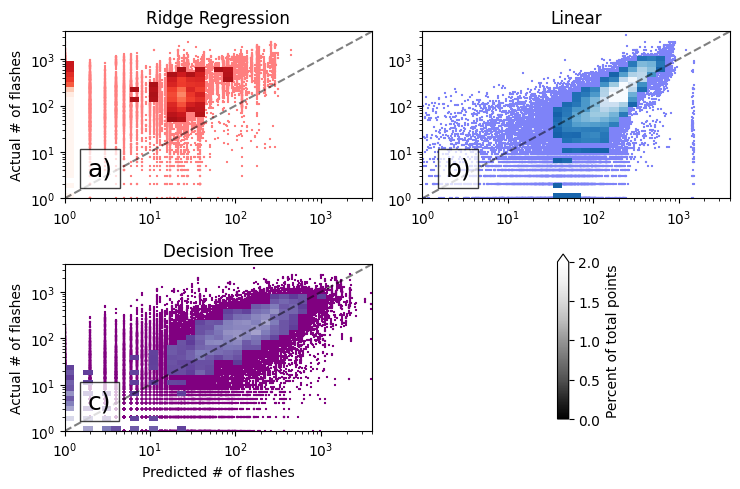

In [43]:
import matplotlib

#make figure with 2 rows and 2 columns with size 7.5" by 5"
fig,axes = plt.subplots(2,2,figsize=(7.5,5))
#set facecolor to white so we can copy paste it if you want to somewhere else
fig.set_facecolor('w')

#the number of bins for the boxbin method 
n = 33
#the bins we want in x and y 
xbins = np.logspace(0,3.5,n)
ybins = np.logspace(0,3.5,n)

#colors i like 
r = [255/255,127/255,127/255]
b = [126/255,131/255,248/255]

#labels
labels= ['Ridge Regression','Linear','Decision Tree']
#color list, one for each model 
colors= [r,b,'purple']
#colormaps to match the colors in 'theme'
cmaps=['Reds_r','Blues_r','Purples_r']

#force ticks to show up where i want them 
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 

#axes is shape [2,3], it is easier to loop if we flatten this, which is what ravel does 
axes = axes.ravel()

#some parameters to make it pretty 
c_scale = 0.575
fs3 = 11
fs4 = 18
props = dict(boxstyle='square', facecolor='White', alpha=0.75)
annotate_list = ['a)','b)','c)']

#draw a new axis for a new colorbar to go on 
ax_cbar = fig.add_axes([0.75, 0.15, 0.015,0.33])
#draw that colorbar 
cbar = make_colorbar(ax_cbar,0,2,plt.cm.Greys_r)
#label that colorbar 
cbar.set_label('Percent of total points')

#loop over axes and draw scatters 
for i,ax in enumerate(axes):
    #we have 1 too many subplots, so turn off the last one [5]
    if i==3:
        ax.axis('off')
        break
    #make axes log-log     
    ax.semilogy()
    ax.semilogx()
    
    #grab model
    model = model_list[i]
    #get predicitions 
    yhat = model.predict(X_validate)
    #make scatter plot 
    ax.scatter(yhat,y_validate,color=colors[i],s=1,marker='+')
    
    #box and bin up data to show density of points 
    ax,cbar,C = boxbin(yhat,y_validate,xbins,ybins,ax=ax,mincnt=100,normed=True,cmap=cmaps[i],vmin=0,vmax=2,cbar=False)
    
    #set some axis limits and ticks 
    ax.set_xlim([1,4000])
    ax.set_xticks([1,10,100,1000])
    ax.set_yticks([1,10,100,1000])
    ax.set_ylim([1,4000])
    
    #add diaganol line 
    ax.plot([1,4000],[1,4000],'--k',alpha=0.5)
    
    #add a subplot label 
    ax.text(0.075, 0.25, annotate_list[i], transform=ax.transAxes,fontsize=fs4,
        verticalalignment='top', bbox=props)
    
    #only label certain axes x-y axis to save space 
    if (i == 0) or (i==2):
        ax.set_ylabel('Actual # of flashes')
    if i==2:
        ax.set_xlabel('Predicted # of flashes')
        
    #label each subplot title as the method used 
    ax.set_title(labels[i])
    
plt.tight_layout()

In [44]:
## try neural nets??

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# three class initializers! 

class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden): 
        super(ACAIGFCN, self).__init__()

        layers = []
        prev_dim = input_dim

        #Define the network layer(s) and activation function(s)
        for hidden_dim in hidden:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        #Define how your model propagates the input through the network

        return self.model(x) # output from second hidden layer! 
    
# separate initializer for dropout regularization 
class dropout_ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden, dropout_prob): 
        super(dropout_ACAIGFCN, self).__init__()

        layers = []
        prev_dim = input_dim

        #Define the network layer(s) and activation function(s)
        for hidden_dim in hidden:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_prob))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        #Define how your model propagates the input through the network

        return self.model(x) # output from second hidden layer! 

# aaand one more for batch normalization
class batch_ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden): 
        super(batch_ACAIGFCN, self).__init__()

        layers = []
        prev_dim = input_dim

        #Define the network layer(s) and activation function(s)
        for hidden_dim in hidden:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        #Define how your model propagates the input through the network

        return self.model(x) # output from second hidden layer!  

In [99]:
# helper functions to do initializations 
def init_rn_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,mean = 0, std=.01)
def init_xa_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
def init_he_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)


# big model function!! does each variation depending on parameters
# spits out: training loss, training accuracy vs epoch; validation acc_vec 
def bigModel(input, output, hidden_vec, learning_rate, epochs, which_optim, dropout, which_init, which_norm):


    # Initialize neural network model with input, output and hidden layer dimensions
    if dropout < 1: # kind of arbitrary but trust (between 0-1 is the layer by layer dropout probability)
        model = dropout_ACAIGFCN(input_dim = input, output_dim = output, hidden = hidden_vec, dropout_prob=dropout) 
    elif which_norm =="Batch":
        model= batch_ACAIGFCN(input_dim = input, output_dim = output, hidden = hidden_vec)
    else:
        model = ACAIGFCN(input_dim = input, output_dim = output, hidden = hidden_vec)
    
    # edit the weights (if applicable)
    if which_init == "RandomNormal":
        model.apply(init_rn_weights)
    if which_init == "XavierNormal":
        model.apply(init_xa_weights)
    if which_init == "HeUniform":
        model.apply(init_he_weights)

    train_loss_list = np.zeros((epochs,))
    val_loss_list = np.zeros((epochs,))
    validation_accuracy_list = np.zeros((epochs,))

    # Define loss function  and optimizer
    loss_func = nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 

    if which_optim == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)# Use optimizers from torch.optim
    elif which_optim == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif which_optim == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        print("not a valid optimizer!")
    

    # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
    # Track the loss and validation accuracy
    for epoch in tqdm.trange(epochs):

        # ACAIGFCN Training 

        # keep track 
        batch_loss = 0

        # loop through each bit of the train_batch 
        for train_features, train_labels in train_batches:

            # Set model into training mode
            model.train()
            

            # Reset gradients, Calculate training loss on model 
            optimizer.zero_grad() # reset gradients

            train_outputs = model(train_features)

            print("features:", train_features.dtype)
            print("labels:",train_labels.dtype)
            
            print("outputs:", train_outputs.dtype)

            #     print(train_outputs)    
            loss = loss_func(train_outputs, train_labels) # calculate training loss
            #train_loss_list[epoch] = loss.item()

            
            # Perfrom optimization, back propagation
            loss.backward()
            
            optimizer.step()

            batch_loss += loss.item() 
    
        # Record loss for the epoch
        train_loss_list[epoch] = batch_loss / num_train_batches # mean of all 
        
        # ACAIGFCN Validation
        val_acc_track = 0

        val_loss = 0

        for val_features, val_labels in val_batches:
            
            # Telling PyTorch we aren't passing inputs to network for training purpose
            with torch.no_grad(): 
                model.eval()
            
                # Compute validation outputs (targets) 
                val_outputs = model(val_features)
                # and compute accuracy 
                val_acc_track += r2_score(val_outputs, val_labels)

                # then keep track of loss
                loss = loss_func(val_outputs, val_labels)
                val_loss += loss.item()

        
        val_loss_list[epoch] = val_loss / num_val_batches # mean of all 

        # Record accuracy for the epoch; print training loss, validation accuracy
        val_acc = val_acc_track / num_val_batches
        
        print("Epoch: "+ str(epoch) +"; Training Loss: " + str(train_loss_list[epoch]) + "; Validation Accuracy:" + str(val_acc) + '%')
        validation_accuracy_list[epoch] = val_acc


    #Calculate accuracy on test set

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        
        acc_vec = []
        
        for test_features, test_labels in test_batches:

            model.eval()

            # Compute validation outputs (targets)
            y_pred_test = model(test_features)
            
            # and compute accuracy 
            acc_vec.append(r2_score(test_labels, y_pred_test))
            
        
        # Compute total (mean) accuracy
        acc = np.mean(acc_vec)

        # Report total (mean) accuracy, can also compute std based on batches
        print("Mean accuracy: "+ str(acc) + "with standard deviation: " + str(np.var(acc_vec)))

    train_loss_list = train_loss_list.reshape(epochs, 1)
    val_loss_list = val_loss_list.reshape(epochs,1)
    validation_accuracy_list = validation_accuracy_list.reshape(epochs, 1)
    
    return train_loss_list, val_loss_list, validation_accuracy_list,  acc_vec

In [51]:
import seaborn as sns

def plot_curves(train_loss_vec, val_loss_vec, validation_accuracy_vec, labels):
    # Plot training loss and validation accuracy throughout the training epochs
    plt.figure(figsize = (12, 6))

    plt.subplot(2, 1, 1)

    for i in range(np.shape(labels)[0]): # loop through a matrix of the train loss crap 
        plt.plot(train_loss_vec[:,i], linewidth = 3, label=labels[i])
        plt.plot(val_loss_vec[:,i], linewidth = 3, linestyle="--", label=labels[i] )
    plt.ylabel("loss", fontsize=20)
    #plt.xlabel("epochs", fontsize=20)
    plt.legend(fontsize=15,ncol=3)

    plt.subplot(2, 1, 2)
    for i in range(np.shape(labels)[0]):
        plt.plot(validation_accuracy_vec[:,i], linewidth = 3, label=labels[i])
    plt.ylabel("validation accuracy", fontsize=20)
    plt.xlabel("epochs", fontsize=20)
    plt.legend(fontsize=15)
    sns.despine()


In [101]:
# how to batch data???
from torch.utils.data import Dataset, DataLoader


(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)
  

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).to(torch.int64)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).to(torch.int64)

X_validate = torch.Tensor(X_validate)
y_validate = torch.Tensor(y_validate).to(torch.int64)



class CustomDataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.labels[idx]
        
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
val_dataset = CustomDataset(X_validate, y_validate)


        


# set batches sizes
train_batch_size = 1024 #Define train batch size
test_batch_size  = 512 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)



print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


train, vloss, vacc, tacc = bigModel(36, 2, [20, 10], 0.1, 15, "SGD", 1, "None", "None")
plot_curves(train, vloss, vacc, ["baseline"])


217
45
95


  0%|          | 0/15 [00:00<?, ?it/s]

features: torch.float32
labels: torch.int64
outputs: torch.float32


IndexError: Target 6 is out of bounds.

Testing Score: 0.9172499888537162
Mean Squared Error: 33385.08047403185


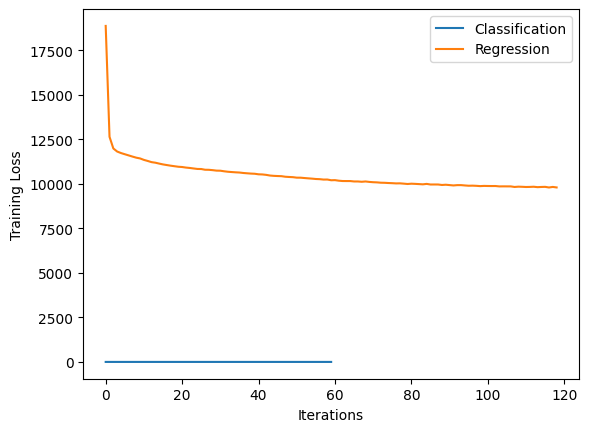

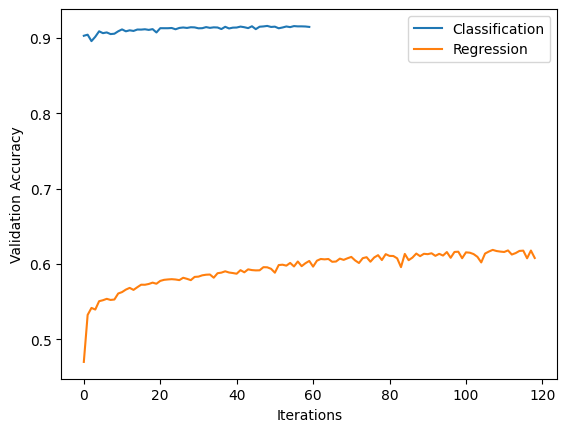

In [ ]:
## take 2: out of the box method
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# classification dataset -- 36 features
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,36,1),class_labels=True)



model = MLPClassifier(solver="adam", max_iter=60,validation_fraction=0.1, random_state=42, early_stopping=True)
model.fit(X_train, y_train)

print("Testing Score: {}".format(model.score(X_test, y_test)))


# regression dataset -- 36
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='data/',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)
 

model2 = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', solver='adam', random_state=42, validation_fraction=0.1, early_stopping=True)
model2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")




plt.plot(model.loss_curve_, label="Classification")
plt.plot(model2.loss_curve_, label="Regression")
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.legend()
plt.show()



plt.plot(model.validation_scores_, label = "Classification")
plt.plot(model2.validation_scores_, label = "Regression")
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()